In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import astropy.units as u
from astropy.table import Column, Table, vstack
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery

from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay

afwDisplay.setDefaultBackend('matplotlib')

Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/dustmaps_cachedata/gbb0a0c949e+81bc2a20b4/config/.dustmapsrc


In [3]:
butler_config = 'dp02'
collections = '2.2i/runs/DP0.2'
butler = Butler(butler_config, collections=collections)

In [4]:
dataId = {'tract': 3828, 'patch': 21}
obj = butler.get('objectTable', dataId=dataId)

In [10]:
dataId_dict = {}
patchmin = 10
patchmax = 25

for patch in range(patchmin, patchmax):
    dataId_dict[patch] = {'tract': 3828, 'patch': patch, 'skymap': 'DC2'}

objtables = {}

for patch in range(patchmin, patchmax):
    objtables[patch] = butler.get('objectTable', dataId=dataId_dict[patch])

objectTable = objtables[patchmin]

for patch in range(patchmin+1, patchmax):
    objectTable = pd.concat([objectTable, objtables[patch]])


In [81]:
umag = (objectTable['u_psfFlux'].values*u.nJy).to(u.ABmag)
gmag = (objectTable['g_psfFlux'].values*u.nJy).to(u.ABmag)
rmag = (objectTable['r_psfFlux'].values*u.nJy).to(u.ABmag)
imag = (objectTable['i_psfFlux'].values*u.nJy).to(u.ABmag)
zmag = (objectTable['z_psfFlux'].values*u.nJy).to(u.ABmag)
ymag = (objectTable['y_psfFlux'].values*u.nJy).to(u.ABmag)
snr_z = (objectTable['z_psfFlux'].values/objectTable['z_psfFluxErr'].values)

iz = imag.value-zmag.value
zy = zmag.value-ymag.value
ug = umag.value-gmag.value
ri = rmag.value-imag.value
gr = gmag.value-rmag.value

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:66: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [49]:
ptsource = (objectTable['z_extendedness'] < 0.5)
snrcut = snr_z > 10.0

Referring to CMD from https://iopscience.iop.org/article/10.3847/1538-4357/aaf1a7/pdf

See also HSC CCD from https://iopscience.iop.org/article/10.3847/0004-637X/828/1/26

In [86]:
ldwarf = (iz > 1.25) # (iz < 2) & (iz > 1) # & (zy > 0.75) & (zy< 1)

In [87]:
np.sum(ldwarf)

30067

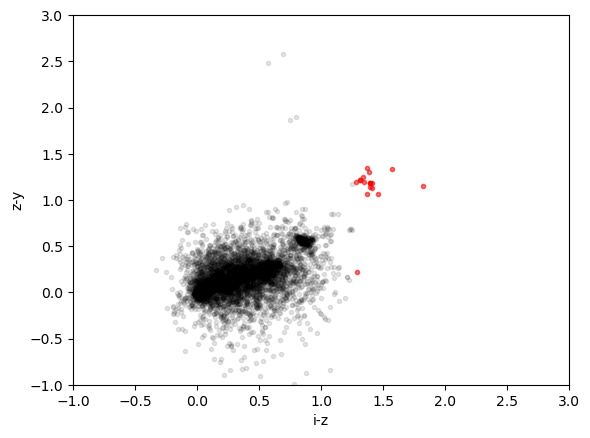

In [88]:
# plt.plot(imag-zmag, zmag-ymag, 'k.', alpha=0.1)
plt.plot(iz[ptsource & snrcut], zy[ptsource & snrcut], 'k.', alpha=0.1)
plt.plot(iz[ptsource & ldwarf & snrcut], zy[ptsource & ldwarf & snrcut], 'r.', alpha=0.5)
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.xlabel('i-z')
plt.ylabel('z-y')
plt.show()

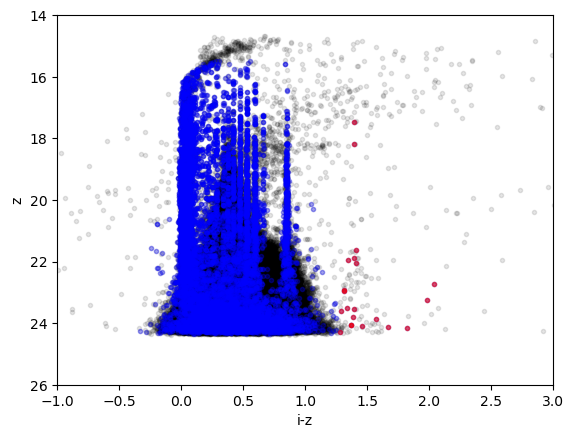

In [89]:
# plt.plot(imag-zmag, zmag-ymag, 'k.', alpha=0.1)
plt.plot(iz[snrcut], zmag[snrcut], 'k.', alpha=0.1)
plt.plot(iz[ptsource & snrcut], zmag[ptsource & snrcut], 'b.', alpha=0.3)
plt.plot(iz[ptsource & ldwarf & snrcut], zmag[ptsource & ldwarf & snrcut], 'r.', alpha=0.5)
plt.xlim(-1, 3)
plt.ylim(26, 14)
plt.xlabel('i-z')
plt.ylabel('z')
plt.show()

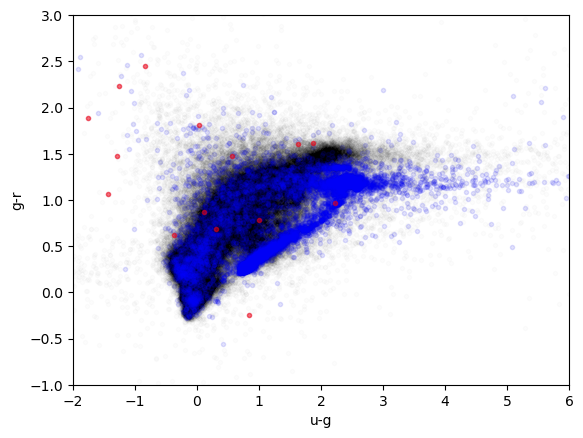

In [94]:
plt.plot(ug[snrcut], gr[snrcut], 'k.', alpha=0.01)
plt.plot(ug[ptsource & snrcut], gr[ptsource & snrcut], 'b.', alpha=0.1)
plt.plot(ug[ptsource & ldwarf & snrcut], gr[ptsource & ldwarf & snrcut], 'r.', alpha=0.5)
plt.xlim(-2, 6)
plt.ylim(-1, 3)
plt.ylabel('g-r')
plt.xlabel('u-g')
plt.show()

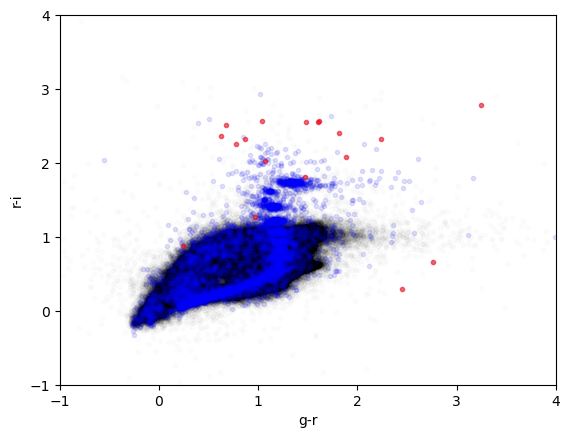

In [95]:
plt.plot(gr[snrcut], ri[snrcut], 'k.', alpha=0.01)
plt.plot(gr[ptsource & snrcut], ri[ptsource & snrcut], 'b.', alpha=0.1)
plt.plot(gr[ptsource & ldwarf & snrcut], ri[ptsource & ldwarf & snrcut], 'r.', alpha=0.5)
plt.xlim(-1, 4)
plt.ylim(-1, 4)
plt.xlabel('g-r')
plt.ylabel('r-i')
plt.show()

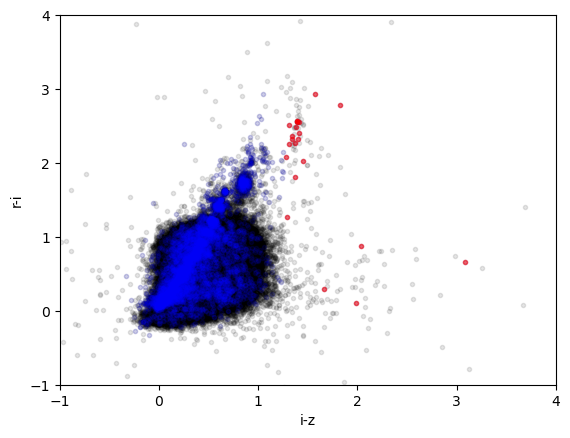

In [97]:
plt.plot(iz[snrcut], ri[snrcut], 'k.', alpha=0.1)
plt.plot(iz[ptsource & snrcut], ri[ptsource & snrcut], 'b.', alpha=0.1)
plt.plot(iz[ptsource & ldwarf & snrcut], ri[ptsource & ldwarf & snrcut], 'r.', alpha=0.5)
plt.xlim(-1, 4)
plt.ylim(-1, 4)
plt.xlabel('i-z')
plt.ylabel('r-i')
plt.show()

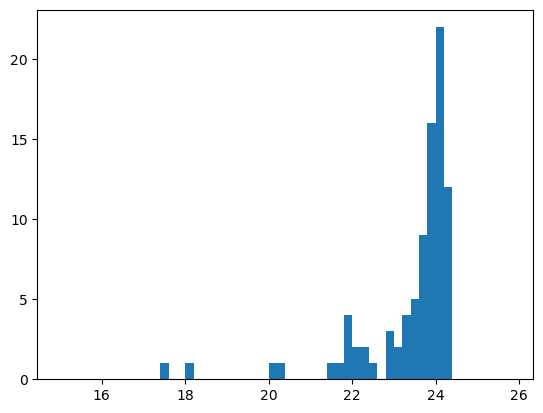

In [66]:
plt.hist(zmag[ptsource & snrcut & ldwarf].value, bins=np.arange(15, 26, 0.2))
plt.show()